# MODEL IMPLEMENTATION AND EVALUATION

This is the stage where the three models are built, optimized and evaluated.

Models used: `` Multinominal Naive Bayes`` , ``Support Vector Machine``, ``Logistic Regression``

Evaluation methods used: ``accuracy, precision, recall, f1_score`` and ``confusion matrix``

## Summary

After appropriate evaluation, LR with count vectorizer has been deemed the best. The rest of the models has all worked above 80% accuracy, with the other metrics working out above 79%. 

In [28]:
#LIBRARIES 
import pandas as pd
import nltk
from nltk.corpus import stopwords
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import pickle
import warnings
warnings.simplefilter("ignore")

In [29]:
#lOADING DATASETS 
df = pd.read_csv(r"C:\Users\Kamakshi\cleaned_data.csv",encoding="latin1") #due to special charas should be encoded as latin 1

toCheck = pd.read_csv(r"C:\Users\Kamakshi\updated_data.csv",encoding="latin1")
#REMOVE MAX
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#DROP EXTRA COLUMNS
df.drop(['Unnamed: 0'], axis=1, inplace=True)
toCheck.drop(['Unnamed: 0'], axis=1, inplace=True)

# DOUBLE-CHECKING...

Double checking if there are any NULL values within the dataset. This would cause issues later on if there are as such.

In [30]:
#CHECKING WHICH ROW IS NULL FROM PRE-PROCESSING
checkNULL = df.isnull()
checkNULL = checkNULL.any(axis=1)
df[checkNULL]

,review_text,verified_purchase
191,NaN,True
523,NaN,True
1072,NaN,True
1111,NaN,True
1230,NaN,True
1316,NaN,True


In [31]:
toCheck = toCheck.drop_duplicates().reset_index(drop=True)

In [32]:
toCheck.iloc[[191,523,1072,1111,1230,1316],[3,4]]

,review_text,verified_purchase
191,A+,True
523,5*,True
1072,very,True
1111,Does what it should,True
1230,A+,True
1316,A*****,True


Checking the old csv file, it can be seen as to why the five rows were totally cleaned out within its review_text. That was because within the text processing stage previously, only words which held meaning were kept, and if we refer to the second table we can see that most of them were either stopwords or had symbols and numbers. Since they don't hold meaning either way, these will be dropped subsequently. 

In [33]:
#DROP THE NULL ROWS
df = df.dropna(how='any',axis=0) 

In [34]:
#UPDATED VP VALUES 
df["verified_purchase"].value_counts(normalize=True)

False    0.525701
True     0.474299
Name: verified_purchase, dtype: float64

The change barely had any affect on the T/F values, and thus we are ready to proceed.

# MODELING

Within the dataset, there are currently only two columns. Out of the two, review_text is going to be assigned as the input variable, and verified_purchases as the target variable. The data is then going to be split accordingly.

In [35]:
#ASSIGN THE VARIABLES
X = df['review_text'] #input var
y = df['verified_purchase'] #target var

In [36]:
#SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    df['review_text'], df['verified_purchase'],test_size=0.4, random_state=42) #40% gives best results, 42 is no of life...

entiredf = format(df.shape[0])
traindf = format(X_train.shape[0])
testdf = format(X_test.shape[0])

print('Number of rows:')
print('Entire dataset:', entiredf)
print('Train dataset:', traindf)
print('Test dataset:',testdf)

Number of rows:
Entire dataset: 1712
Train dataset: 1027
Test dataset: 685


The data is decided to be split into 60 - 40, which has been determined by trial and error. This splitting produces the highest accuracy for the models, and thus we are going to with that. 

## COUNT VECTORIZER AND MODELING

word vectorization maps words or phrases from a lexicon to a matching vector of real numbers, which may then be used to determine word predictions and semantics, and this is done due to the fact that models only understand numerical data.

We are going to be utlizing two of the vectorization methods, the first one being count vectorizer. We just count the number of times a word appears in the document in CountVectorizer, which results in a bias in favor of the most common terms.

In [37]:
count_vectorizer  = CountVectorizer(stop_words='english')
count_vectorizer.fit(X_train)
print('\nVocabulary: \n', count_vectorizer.vocabulary_)

train_c = count_vectorizer.fit_transform(X_train)
test_c = count_vectorizer.transform(X_test)


Vocabulary: 
 {'current': 413, 'sell': 1498, 'price': 1310, 'compar': 341, 'supermarket': 1705, 'good': 760, 'smell': 1563, 'pleasant': 1270, 'need': 1134, 'add': 14, 'small': 1558, 'cloth': 319, 'fresh': 700, 'great': 776, 'moisturis': 1100, 'sensit': 1502, 'love': 1009, 'pour': 1293, 'smaller': 1559, 'bottl': 193, 'make': 1032, 'manag': 1036, 'beat': 136, 'decent': 432, 'fabric': 614, 'soften': 1580, 'nice': 1142, 'fragranc': 695, 'purchas': 1334, 'deliveri': 456, 'cream': 397, 'handwash': 801, 'cheaper': 281, 'hand': 798, 'better': 154, 'liquid': 988, 'oh': 1174, 'wing': 1917, 'dove': 514, 'kitchen': 940, 'bathroom': 131, 'shower': 1527, 'room': 1436, 'recommend': 1378, 'highli': 830, 'star': 1636, 'simpl': 1537, 'gel': 727, 'like': 977, 'glue': 753, 'hard': 805, 'rub': 1444, 'slip': 1555, 'bath': 130, 'goe': 756, 'smoothli': 1569, 'easili': 539, 'wast': 1885, 'leav': 964, 'feel': 643, 'silki': 1535, 'soft': 1579, 'scenti': 1477, 'review': 1419, 'collect': 326, 'promot': 1322, 'exc

### Multinomial Naive Bayes model

In [38]:
#IMPLEMENTING AND RUNNNING MNB MODEL - COUNT
mnb1 = MultinomialNB()
mnb1.fit(train_c, y_train)
prediction = mnb1.predict(test_c)

In [39]:
#EVALUATION
mnb_a1 = accuracy_score(y_test, prediction)*100
mnb_p1 = precision_score(y_test, prediction)* 100
mnb_r1 = recall_score(y_test, prediction)*100
mnb_f11 = f1_score(y_test, prediction)*100

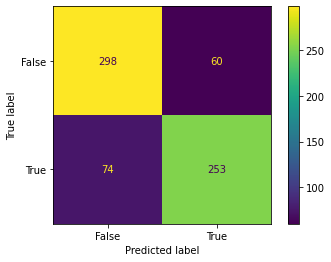

In [40]:
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=mnb1.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=mnb1.classes_) 
display.plot() 

### Support Vector Machine model

In [41]:
#IMPLEMENTING AND RUNNNING SVM MODEL - COUNT
svm1 = SVC(kernel='linear')
svm1.fit(train_c, y_train)
prediction = svm1.predict(test_c)

In [42]:
#EVALUATION
svm_a1 = accuracy_score(y_test, prediction)*100
svm_p1 = precision_score(y_test, prediction)* 100
svm_r1 = recall_score(y_test, prediction)*100
svm_f11 = f1_score(y_test, prediction)*100

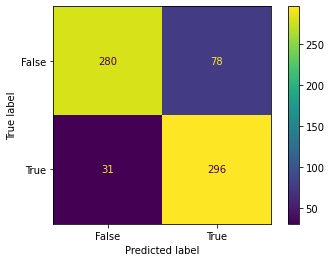

In [43]:
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=svm1.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm1.classes_) 
display.plot() 

### Logistic Regression model

In [44]:
#IMPLEMENTING AND RUNNNING LR MODEL - COUNT
lr1 = LogisticRegression()
lr1.fit(train_c, y_train)
prediction = lr1.predict(test_c)

In [45]:
#EVALUATION
lr_a1 = accuracy_score(y_test, prediction)*100
lr_p1 = precision_score(y_test, prediction)* 100
lr_r1 = recall_score(y_test, prediction)*100
lr_f11 = f1_score(y_test, prediction)*100

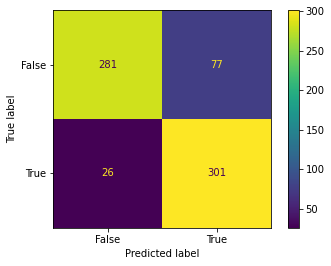

In [46]:
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=lr1.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr1.classes_) 
display.plot() 

# Decision- Tree

In [47]:
 #IMPLEMENTING AND RUNNNING Decision Tree
d1=DecisionTreeClassifier(random_state=42)
d1.fit(train_c, y_train)
prediction = d1.predict(test_c)
 


In [74]:
#EVALUATION
d1_a1 = accuracy_score(y_test, prediction)*100
d1_p1 = precision_score(y_test, prediction)* 100
d1_r1 = recall_score(y_test, prediction)*100
d1_f11 = f1_score(y_test, prediction)*100
print(d1_p1)

83.125


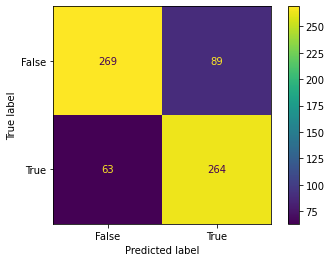

In [49]:
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=d1.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=d1.classes_) 
display.plot()

## TFIDF VECTORIZER AND MODELING

We examine the total document weightage of a word in TfidfVectorizer. It assists us in coping with the most common terms. We may use it to penalize them. The word counts are weighted by a measure of how frequently they appear in the documents in TfidfVectorizer.

# Decision Tree using TFIDF Vector

In [55]:
TFIDF_vectorizer  = TfidfVectorizer(stop_words='english')

TFIDF_vectorizer.fit(X_train)
print('\nVocabulary: \n', TFIDF_vectorizer.vocabulary_)

train_tf = TFIDF_vectorizer.fit_transform(X_train)
test_tf = TFIDF_vectorizer.transform(X_test)


Vocabulary: 
 {'like': 1122, 'simpl': 1765, 'brand': 227, 'sensit': 1722, 'need': 1304, 'realli': 1573, 'care': 288, 'chemic': 323, 'face': 707, 'moisturis': 1258, 'fantast': 725, 'littl': 1139, 'smell': 1795, 'gel': 840, 'consist': 407, 'sticki': 1895, 'gloopi': 863, 'market': 1195, 'appli': 84, 'sink': 1772, 'quickli': 1548, 'leav': 1106, 'feel': 741, 'refresh': 1592, 'heavi': 942, 'reaction': 1567, 'combin': 373, 'ideal': 997, 'greasi': 892, 'hour': 979, 'wear': 2180, 'total': 2059, 'normal': 1325, 'sometim': 1826, 'creami': 445, 'makeup': 1185, 'easili': 621, 'short': 1754, 'period': 1421, 'time': 2036, 'sunk': 1950, 'light': 1118, 'wrinkl': 2235, 'perform': 1418, 'miracl': 1240, 'prevent': 1506, 'dri': 600, 'day': 478, 'effect': 629, 'heat': 941, 'sun': 1947, 'think': 2021, 'best': 175, 'job': 1064, 'longer': 1147, 'cheaper': 316, 'end': 645, 'shampoo': 1737, 'make': 1183, 'hair': 913, 'shini': 1751, 'soft': 1815, 'bodi': 207, 'tini': 2039, 'bit': 185, 'goe': 871, 'long': 1146, '

In [75]:
# Import necessary librariesfrom sklearn.model_selection import train_test_split
""""from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have a DataFrame 'df' with features and a target variable 'fake_review'
# Replace 'review_text' and 'fake_review' with your actual text column and target column names

# Extract features and target variable
X = df['review_text']  # Replace with your text column
y = df['verified_purchase']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)"""

# Create a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Train the model
decision_tree_model.fit(train_tf, y_train)

# Make predictions on the test set
predictions = decision_tree_model.predict(test_tf)

# Evaluate the model
accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

#conf_matrix = confusion_matrix(y_test, predictions)
d1_a2= accuracy*100
d1_p2=precision*100
d1_r2=recall*100
d1_f2=f1*100
# Print the evaluation metrics
print(f"Accuracy: {accuracy*100}")
print(f"Precision: {precision*100}")
print(f"Recall: {recall*100}")
print(f"F1 Score: {f1*100}")
print("Confusion Matrix:")
#print(conf_matrix)



Accuracy: 81.63265306122449
Precision: 83.125
Recall: 78.69822485207101
F1 Score: 80.85106382978724
Confusion Matrix:


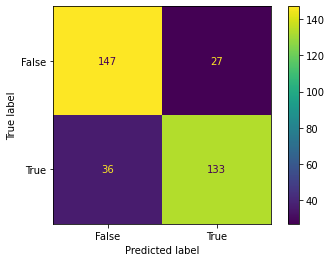

In [76]:
cm1 =  confusion_matrix(y_test, prediction, labels=decision_tree_model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm1,
                              display_labels=decision_tree_model.classes_) 
display.plot() 

### Multinomial Naive Bayes model

In [58]:
#IMPLEMENTING AND RUNNING MNB MODEL - TFIDF
mnb2 = MultinomialNB()
mnb2.fit(train_tf, y_train)
prediction = mnb2.predict(test_tf)

In [59]:
#EVALUATION
mnb_a2 = accuracy_score(y_test, prediction)*100
mnb_p2 = precision_score(y_test, prediction)* 100
mnb_r2 = recall_score(y_test, prediction)*100
mnb_f12 = f1_score(y_test, prediction)*100

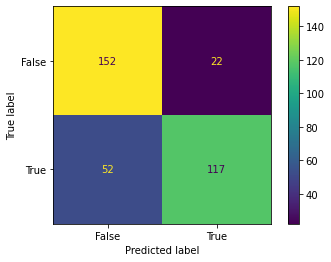

In [60]:
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=mnb2.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=mnb2.classes_) 
display.plot() 

### Support Vector Machine model

In [61]:
#IMPLEMENTING AND RUNNING SVM MODEL - TFIDF 
svm2 = SVC(kernel='linear')
svm2.fit(train_tf, y_train)
prediction = svm2.predict(test_tf)

In [62]:
#EVALUATION
svm_a2 = accuracy_score(y_test, prediction)*100
svm_p2 = precision_score(y_test, prediction)* 100
svm_r2 = recall_score(y_test, prediction)*100
svm_f12 = f1_score(y_test, prediction)*100

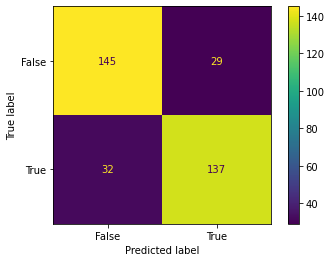

In [63]:
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=svm2.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm2.classes_) 
display.plot() 

### Logistic Regression model

In [64]:
#IMPLEMENTATION AND RUNNING LR MODEL - TFIDF 
lr2 = LogisticRegression()
lr2.fit(train_tf, y_train)
prediction = lr2.predict(test_tf)

In [65]:
#EVALUATION
lr_a2 = accuracy_score(y_test, prediction)*100
lr_p2 = precision_score(y_test, prediction)* 100
lr_r2 = recall_score(y_test, prediction)*100
lr_f12 = f1_score(y_test, prediction)*100

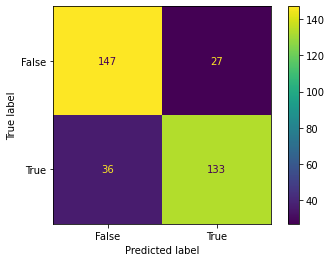

In [66]:
#CONFUSION MATRIX
cm =  confusion_matrix(y_test, prediction, labels=lr2.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr2.classes_) 
display.plot() 

### COMPARING ACCURACY

In [78]:
model_accuracy={'MNB': [round(mnb_a1), round(mnb_a2)],
                'SVM': [round(svm_a1), round(svm_a2)],
                'LR': [round(lr_a1), round(lr_a2)],
                 'Decisiontree':[round(d1_a1),round(d1_a2)]
               }
ma = pd.DataFrame(model_accuracy, columns = ['MNB','SVM','LR','Decisiontree'], index=['Count Vectorizer','Tfidf Vectorizer'])
ma

,MNB,SVM,LR,Decisiontree
Count Vectorizer,80,84,85,82
Tfidf Vectorizer,78,82,82,82


### COMPARING PRECISION

In [88]:
model_precision={'MNB': [round(mnb_p1), round(mnb_p2)],
                'SVM': [round(svm_p1), round(svm_p2)],
                'LR': [round(lr_p1), round(lr_p2)],
                       'Decisiontree':[round(d1_p1), round(d1_p2)]
               }
mp = pd.DataFrame(model_precision, columns = ['MNB','SVM','LR','Decisiontree'], index=['Count Vectorizer','Tfidf Vectorizer'])
mp

,MNB,SVM,LR,Decisiontree
Count Vectorizer,81,79,80,83
Tfidf Vectorizer,84,83,83,83


### COMPARING RECALL

In [84]:
model_recall={'MNB': [round(mnb_r1), round(mnb_r2)],
                'SVM': [round(svm_r1), round(svm_r2)],
                'LR': [round(lr_r1), round(lr_r2)],
                       'Decisiontree':[round(d1_r1), round(d1_r2)]
               }
mr = pd.DataFrame(model_recall, columns = ['MNB','SVM','LR','Decisiontree'], index=['Count Vectorizer','Tfidf Vectorizer'])
mr

,MNB,SVM,LR,Decisiontree
Count Vectorizer,77,91,92,79
Tfidf Vectorizer,69,81,79,79


### COMPARING F1 SCORE

In [87]:
model_f1={'MNB': [round(mnb_f11), round(mnb_f12)],
                'SVM': [round(svm_f11), round(svm_f12)],
                'LR': [round(lr_f11), round(lr_f12)],
                       'Decisiontree':[round(d1_f11),round(d1_f2)]
               }
mf1 = pd.DataFrame(model_f1, columns = ['MNB','SVM','LR','Decisiontree'], index=['Count Vectorizer','Tfidf Vectorizer'])
mf1

,MNB,SVM,LR,Decisiontree
Count Vectorizer,79,84,85,81
Tfidf Vectorizer,76,82,81,81


In [36]:
import pickle
# Assuming lr1 is your model and count_vectorizer is your vectorizer
pickle.dump(lr1, open(r"C:\Users\YATI\Downloads\best_model.pkl", 'wb'))
pickle.dump(count_vectorizer, open(r"C:\Users\YATI\Downloads\count_vectorizer.pkl", 'wb'))


In [37]:
import pickle

# Load the model
with open("best_model.pkl", 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Load the vectorizer
with open("count_vectorizer.pkl", 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

# Print or inspect the loaded objects
print("Model loaded successfully:", loaded_model)
print("Vectorizer loaded successfully:", loaded_vectorizer)


Model loaded successfully: LogisticRegression()
Vectorizer loaded successfully: CountVectorizer(stop_words='english')
